## Data load and visualization

In [2]:
import pandas as pd
import numpy as np
path = r"E:\anaconda\Machine learning\iris.data"
names = ['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']
data = pd.read_csv(path, names=names)
data.loc[data['class']=='Iris-virginica','class']=2
data.loc[data['class']=='Iris-versicolor','class']=1
data.loc[data['class']=='Iris-setosa','class'] = 0
data

,sepal_len,sepal_wid,petal_len,petal_wid,class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


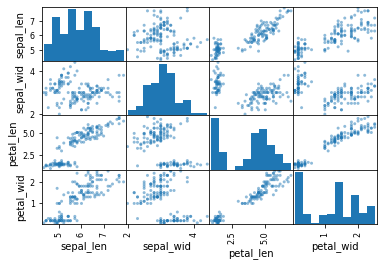

In [3]:
# Use scatter matrix to show the corelations
from pandas.plotting import scatter_matrix
from matplotlib import pyplot as plt
scatter_matrix(data)
plt.show()

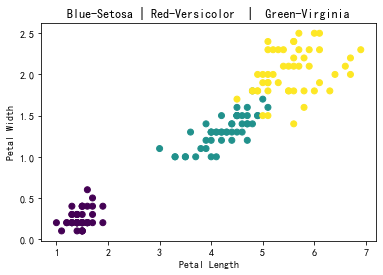

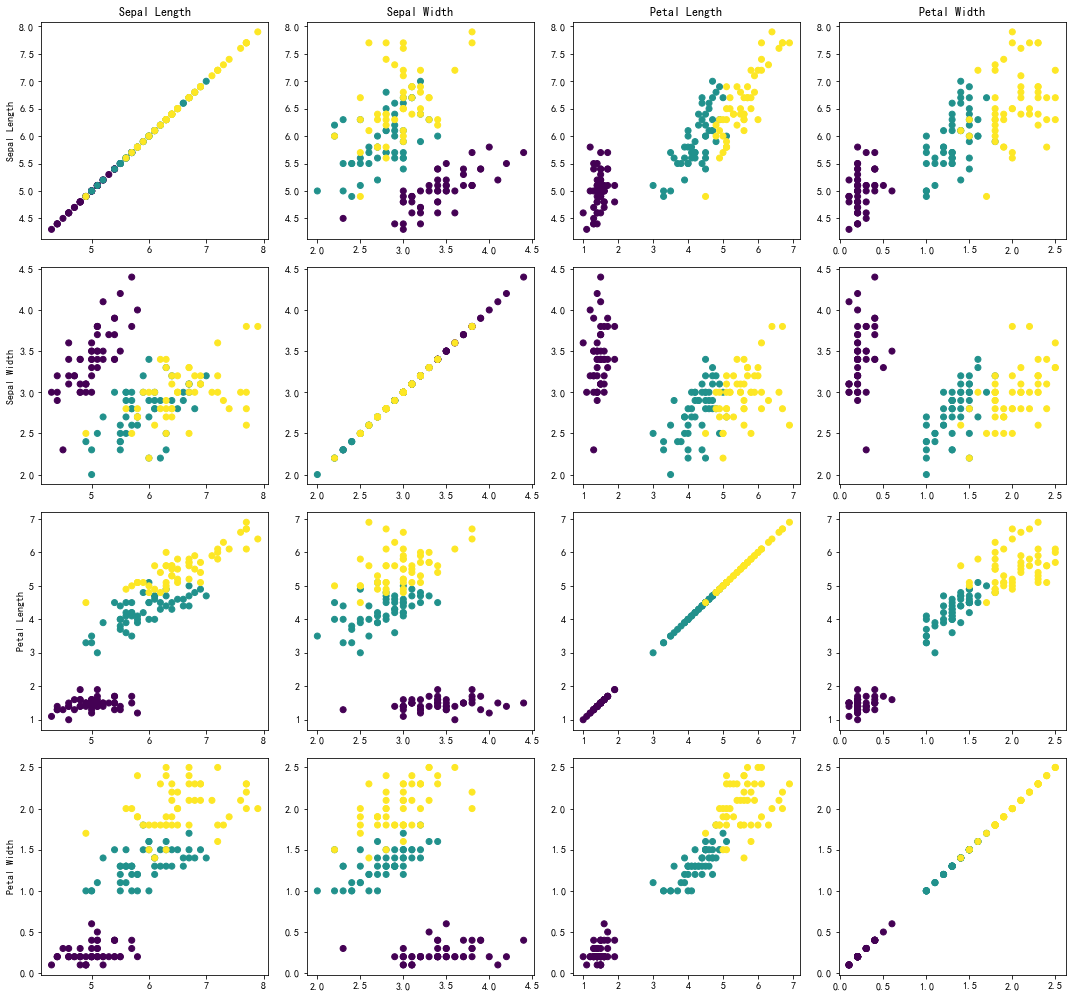

In [4]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

iris = np.array(data)

plt.scatter(iris[:, 2], iris[:, 3],c=iris[:, 4])
plt.title("Blue-Setosa | Red-Versicolor  |  Green-Virginia")
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.show()

fig = plt.figure('Iris Data', figsize=(15,15))

COLUMN_NAMES = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width', 'Species']
for i in range(4):
    for j in range(4):
        plt.subplot(4, 4, 4*i+(j + 1))
        plt.scatter(iris[:, j], iris[:, i], c=iris[:, 4])

        if(i==0):
            plt.title(COLUMN_NAMES[j])
        if(j==0):
            plt.ylabel(COLUMN_NAMES[i])

plt.tight_layout(rect=[0,0,1,0.93])
plt.savefig('iris.png')
plt.show()


# Set up Model

## Import Packages

In [56]:
import pandas as pd
import numpy as np
import datetime
from sklearn.utils import shuffle
from sklearn.metrics import recall_score
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

## Load Data

In [57]:
def load_data():
    # load data
    path = r"E:\anaconda\Machine learning\iris.data"
    names = ['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']
    data = pd.read_csv(path, names=names)
    data.loc[data['class'] == 'Iris-virginica', 'class'] = 2
    data.loc[data['class'] == 'Iris-versicolor', 'class'] = 1
    data.loc[data['class'] == 'Iris-setosa', 'class'] = 0
    x = data[['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid']].values
    y = data['class'].values
    # training data and test data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)
    y_trian = y_train.T
    y_test = y_test.T
    x_train = x_train.T
    x_test = x_test.T
    # transfer into one-hot encoding
    y_train_onehot = np.zeros((y_train.shape[0], 3))
    y_train_onehot[np.arange(y_train.shape[0]), y_train.astype('int64')] = 1
    y_test_onehot = np.zeros((y_test.shape[0], 3))
    y_test_onehot[np.arange(y_test.shape[0]), y_test.astype('int64')] = 1
    y_train = y_train_onehot.T
    y_test = y_test_onehot.T
    return x, y, x_train, x_test, y_train, y_test

## BP Neural Network

In [74]:
class NeuralNetwork:
    def __init__(self, n_h, n_input, n_output):
        self.n_h = n_h
        self.n_input = n_input
        self.n_output = n_output

        # parameters initialization
        self.w1 = np.random.randn(self.n_h, self.n_input) * 0.1
        self.w2 = np.random.randn(self.n_output, self.n_h) * 0.1
        self.b1 = np.zeros((self.n_h, 1))
        self.b2 = np.zeros((self.n_output, 1))
        
        
    def forward(self, X):
        # Use two hidden layers with the activatin function tanh
        self.z1 = np.dot(self.w1, X) + self.b1
        self.a1 = np.tanh(self.z1)
        self.z2 = np.dot(self.w2, self.a1) + self.b2
        y_pred = np.tanh(self.z2)
        return y_pred
    
    def loss_func(self, y_pred, y):
        m = y.shape[1]
        # Compute cross-entropy loss
        log = np.multiply(np.log(np.abs(y_pred)), y) + np.multiply((1 - y), np.log(np.abs(1 - y_pred)))
        loss = - np.sum(log) / m
        return loss
    
    def backward(self, X, y, y_pred, lr):
        m = y.shape[1]
        dz2 = y_pred - y
        dw2 = (1 / m) * np.dot(dz2, self.a1.T)
        db2 = (1 / m) * np.sum(dz2, axis=1, keepdims=True)
        dz1 = np.multiply(np.dot(self.w2.T, dz2), 1 - np.power(self.a1, 2))
        dw1 = (1 / m) * np.dot(dz1, X.T)
        db1 = (1 / m) * np.sum(dz1, axis=1, keepdims=True)
        # update parameters
        self.w1 = self.w1 - lr * dw1
        self.b1 = self.b1 - lr * db1
        self.w2 = self.w2 - lr * dw2
        self.b2 = self.b2 - lr * db2
        
    def train(self, X, y, x_test, y_test, lr, epochs):
        accs = []
        recalls = []
        losses = []
        for epoch in range(epochs):
            y_pred = self.forward(X)
            loss = self.loss_func(y_pred, y)
            self.backward(X, y, y_pred, lr)
            acc, recall = self.predict(x_test, y_test)
            if epoch % 100 == 0:
                accs.append(acc)
                recalls.append(recall)
                losses.append(loss)
        print("accuracy: ", accs)
        print("recall: ", recalls)
        x = [i*10 for i in range(0, 500, 10)]
        plt.title("accuracy")
        plt.plot(x, accs[:501], color='blue')
        plt.xlabel('iteration')
        plt.ylabel('accuracy')
        plt.savefig('acc.png')
        plt.show()

        plt.title("recall")
        plt.plot(x, accs[:501], color='blue')
        plt.xlabel('iteration')
        plt.ylabel('recall')
        plt.savefig('recall.png')
        plt.show()

        plt.title("loss")
        plt.plot(x, losses[:501], color='blue')
        plt.xlabel('iteration')
        plt.ylabel('loss')
        plt.savefig('loss.png')
        plt.show()
            
    def predict(self, X, y):
        y_pred = self.forward(X)
        n_rows = y.shape[0]
        n_cols = y.shape[1]
        output = np.empty(shape=(n_rows, n_cols), dtype=int)
        # Change the probability into 1/0
        for i in range(n_cols):
            temp = np.zeros(shape=n_rows)
            for j in range(n_rows):
                temp[j] = y_pred[j][i]
            # sort the element and output the index
            sorted_dist = np.argsort(temp)
            length = len(sorted_dist)
            
            for k in range(length):
                if k == sorted_dist[length - 1]:
                    output[k][i] = 1
                else:
                    output[k][i] = 0
                    
        output_T = output.T
        y_test_T = y_test.T
        y_predicts = []
        ys = []
        # Find where is 1 and calculate accuracy and recall
        for n in output_T:
            y_predict = np.where(n==1)
            y_predicts.append(int(y_predict[0]))
        for n in y_test_T:
            y = np.where(n==1)
            ys.append(int(y[0]))
        # recall
        recall = recall_score(ys, y_predicts, average='macro')
        # accuracy
        y_predicts = np.array(y_predicts)
        ys = np.array(ys)
        acc = np.sum(np.equal(y_predicts, ys)) / ys.shape[0]
        return acc, recall

accuracy:  [0.3, 0.6833333333333333, 0.6833333333333333, 0.6833333333333333, 0.6833333333333333, 0.6833333333333333, 0.6833333333333333, 0.6833333333333333, 0.6833333333333333, 0.7, 0.7666666666666667, 0.8, 0.85, 0.9166666666666666, 0.9333333333333333, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667, 0.9833333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
recall:  [0.3333333333333333, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6842105263157894, 0.7543859649122807, 0.7894736842105262, 0.8421052631578947, 0.912280701754386, 0.9298245614035089, 0.9649122807017544, 0.9649122807017544, 0.9649122807017544, 0.9824561403508771, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

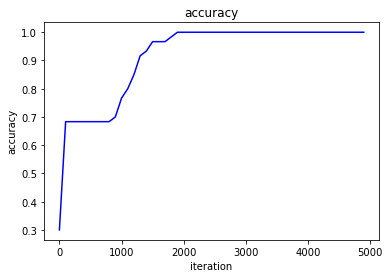

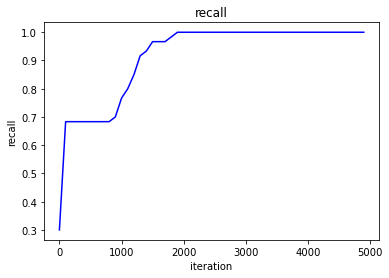

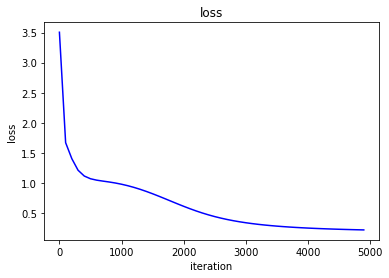

In [75]:
x, y, x_train, x_test, y_train, y_test = load_data()
nn = NeuralNetwork(n_h=8, n_input=4, n_output=3)
nn.train(x_train, y_train, x_test, y_test, learning_rate=0.01, epochs=5000)